In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# 1. Подготовка данных

In [3]:
to_drop = ['feature_3', 'feature_12', 'feature_53', 'feature_65', 'feature_71', 'feature_77',
           'feature_0', 'feature_73', 'feature_74', 'feature_75']

train_df = pd.read_csv("../data/train_df.csv")
train_df = train_df.drop(to_drop, axis=1)
test_df = pd.read_csv("../data/test_df.csv")
test_df = test_df.drop(to_drop, axis=1)

In [4]:
X_train = train_df.drop(["search_id", "target"], axis=1).values
y_train = train_df["target"].to_numpy(dtype=np.float32)
queries_train = train_df["search_id"].values

sorted_idx = np.argsort(queries_train)
X_train = X_train[sorted_idx, :]
y_train = y_train[sorted_idx]
queries_train = queries_train[sorted_idx]


X_test = test_df.drop(["search_id", "target"], axis=1).values
y_test = test_df["target"].to_numpy(dtype=np.float32)
queries_test = test_df["search_id"].values

sorted_idx = np.argsort(queries_test)
X_test = X_test[sorted_idx, :]
y_test = y_test[sorted_idx]
queries_test = queries_test[sorted_idx]

# 2. Выбор параметров модели

Обучение XGBRanker будет производится на NPU. 
Параметр tree_method="exact", поскольку датасет небольшой и временные затраты на полный подсчет Гессиана на каждой итерации не существены [ref](https://arxiv.org/abs/1603.02754).

Для бейзлайна используем параметры дерева: 'max_depth': 2, для "надежности" алгоритма.

# 3. Обучение модели

Будем обучать модель на подвыборках из StratifiedKFold. Разбиваем данные на тренировочные и валидационные. Далее обучаем модель, с помощью валидационной выборки пытаемся выбирать оптимальную итерацию, после чего считаем ndcg на тестовой выборке.

Таким образом получим статистические свойства полученного алгоритма ранжирования.

In [ ]:
from sklearn.model_selection import StratifiedKFold

params = {'objective': 'rank:ndcg', 
          'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators': 50,
          'lambdarank_num_pair_per_sample': 4, 
          "tree_method": "exact",
          "lambdarank_pair_method": "topk", 
          "eval_metric": ["ndcg@10000"]
          }

scores_list = []

for j in range(10):
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(X_train, queries_train)):
        x_train_kf = X_train[train_index]
        y_train_kf = y_train[train_index]
        queries_train_kf = queries_train[train_index]

        x_val_kf = X_train[val_index]
        y_val_kf = y_train[val_index]
        queries_val_kf = queries_train[val_index]
        
        ranker = xgb.XGBRanker(**params)
        ranker.fit(x_train_kf, y_train_kf, qid=queries_train_kf, eval_set=[(x_val_kf, y_val_kf)], eval_qid=[queries_val_kf], early_stopping_rounds=10)

        scores_list.append(ranker.score(X_test, y_test))

Среднее значение NDCG: 0.5245368438678761


Text(0.5, 0, 'NDCG')

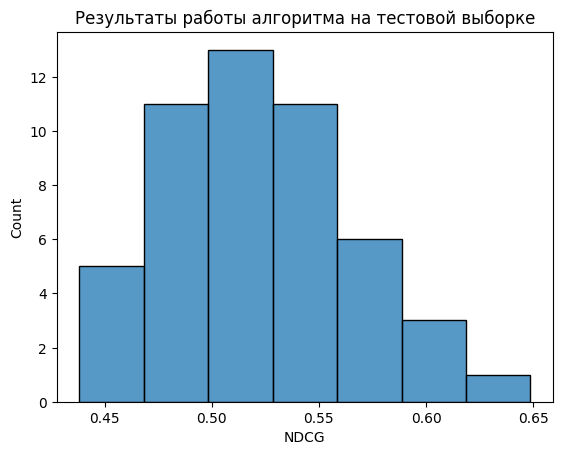

In [185]:
print(f"Среднее значение NDCG: {np.mean(scores_list)}")
sns.histplot(scores_list)
plt.title("Результаты работы алгоритма на тестовой выборке")
plt.xlabel("NDCG")

## Получаем $\text{NDCG}\approx$ 0.5245